# Effect of deploying solar energy in Lexington, KY

## COLLECT DATA

### Initial Demand Curve

,Demand (W)
dt,
2013-01-01 00:00:00,2409120.0
2013-01-01 01:00:00,2409120.0
2013-01-01 02:00:00,2397600.0
2013-01-01 03:00:00,2377440.0
2013-01-01 04:00:00,2404800.0


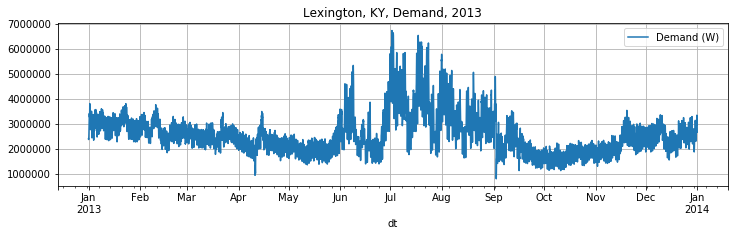

In [7]:
%matplotlib inline
import pandas as pd
from datetime import datetime as dt, timedelta
# uncomment below if you'd like to be able to zoom in graphics
# import mpld3
# mpld3.enable_notebook()
style = {'figsize': (12, 3), 'grid': True}


df_before = pd.read_csv('Demand.csv', names=['demand'])
df_before['dt'] = [(dt(2013, 1, 1) + timedelta(hours=1)*x) for x in range(8760)]
df_before = df_before.set_index('dt')
df_before.columns=['Demand (W)']
df_before['Demand (W)'] *= 1000 # convert to W
df_before.plot(title='Lexington, KY, Demand, 2013', **style)
df_before.head()

### Solar Generation Curve

,Solar Output (W)
dt,
2013-01-01 00:00:00,0.000000e+00
2013-01-01 01:00:00,0.000000e+00
2013-01-01 02:00:00,0.000000e+00
2013-01-01 03:00:00,0.000000e+00
2013-01-01 04:00:00,0.000000e+00
2013-01-01 05:00:00,0.000000e+00
2013-01-01 06:00:00,0.000000e+00
2013-01-01 07:00:00,0.000000e+00
2013-01-01 08:00:00,2.062640e+06


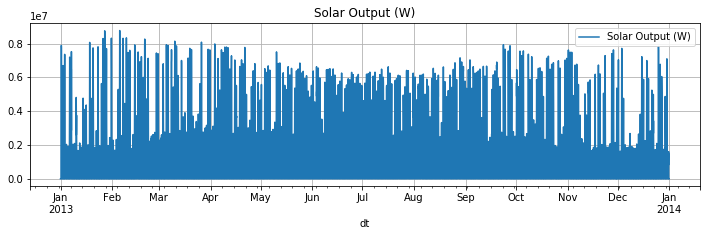

In [4]:
import json
JSON_FILE = 'SolarOutput.json'
with open(JSON_FILE) as f:
    solar_energy = json.load(f)['Consumption']['Power']

df_carve = pd.DataFrame(solar_energy, columns=['Solar Output (W)'])
df_carve['dt'] = [(dt(2013, 1, 1) + timedelta(hours=1)*x) for x in range(8760)]
df_carve.set_index('dt', inplace=True)
df_carve *= 1000 # convert to W
df_carve.plot(title='Solar Output (W)', **style)
df_carve.head(24)

### New Demand Curve

dt
2013-01-01 00:00:00    2409120.0
2013-01-01 01:00:00    2409120.0
2013-01-01 02:00:00    2397600.0
2013-01-01 03:00:00    2377440.0
2013-01-01 04:00:00    2404800.0
dtype: float64

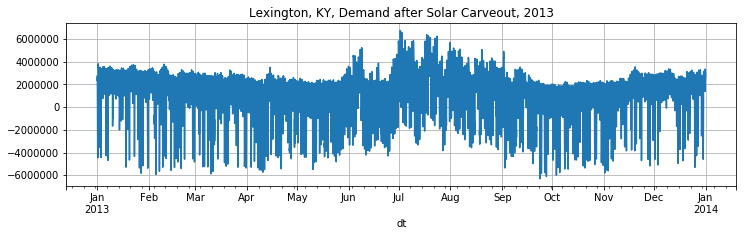

In [8]:
df_after = df_before['Demand (W)'] - df_carve['Solar Output (W)']
df_after.plot(title='Lexington, KY, Demand after Solar Carveout, 2013', **style)
df_after.head()

In [9]:
df_after.to_csv('Carveout.csv') # NOTE: sending to CSV in Watts

## CALCULATIONS

In [10]:
# place everything in one dataframe for analysis
df = pd.DataFrame([df_before.index, df_before['Demand (W)'], df_after]).T
df = df.set_index(0)
df.index.name = 'dt'
df.columns = ['before', 'after']
df.head()

,before,after
dt,,
2013-01-01 00:00:00,2.40912e+06,2.40912e+06
2013-01-01 01:00:00,2.40912e+06,2.40912e+06
2013-01-01 02:00:00,2.3976e+06,2.3976e+06
2013-01-01 03:00:00,2.37744e+06,2.37744e+06
2013-01-01 04:00:00,2.4048e+06,2.4048e+06


# ANNUAL TESTING ---------------------------------------------------

In [11]:
bMax = df['before'].max()
aMax = df['after'].max()
bSum = df['before'].sum()
aSum = df['after'].sum()
aSum_pos = df[df['after'] >= 0]['after'].sum()

print('Annual Max (W)')
print('\tBEFORE:\t', bMax)
print('\tAFTER:\t', aMax)
print('\t% DIF:\t {:.2f}%\n'.format((aMax - bMax)/bMax*100))

print('Annual Demand (kW)')
print('\tBEFORE:\t {:.2f}'.format(bSum/1000))
print('\tAFTER:\t {:.2f}'.format(aSum/1000))
print('\t% DIF:\t {:.2f}%\n'.format((aSum - bSum)/bSum*100))

print('Annual Demand (kW) (no storage, positive only)')
print('\tAFTER:\t {:.2f}'.format(aSum_pos/1000))
print('\t% DIF:\t {:.2f}%\n'.format((aSum_pos - bSum)/bSum*100))


Annual Max (W)
	BEFORE:	 6746400.0
	AFTER:	 6746400.0
	% DIF:	 0.00%

Annual Demand (kW)
	BEFORE:	 22663357.92
	AFTER:	 10861754.21
	% DIF:	 -52.07%

Annual Demand (kW) (no storage, positive only)
	AFTER:	 15192513.45
	% DIF:	 -32.96%



# MONTHLY TESTING ---------------------------------------------------

In [12]:
tests = {'monthly max': 'max', 'monthly sum': 'sum'}
aggregation = {'before': tests, 'after': tests}
df_agg_month = df.groupby(df.index.month).agg(aggregation)

# what if no storage? (remove all negative demand values from sum calculation)
df_positive = df[df['after'] >= 0]
df_agg_month['after', 'no storage'] = df_positive.groupby(df_positive.index.month).sum()['after']
df_agg_month

/anaconda3/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


before                       after                            
   monthly max   monthly sum   monthly max   monthly sum    no storage
dt                                                                    
1    3817440.0  2.192216e+09  3.817440e+06  1.379347e+09  1.664091e+09
2    3774240.0  1.819984e+09  3.774240e+06  9.704641e+08  1.303257e+09
3    3457440.0  1.841376e+09  3.267360e+06  8.214099e+08  1.210612e+09
4    3500640.0  1.606514e+09  3.500640e+06  4.805815e+08  9.762962e+08
5    3597120.0  1.546322e+09  3.597120e+06  3.952474e+08  8.924216e+08
6    5811840.0  1.993841e+09  5.811117e+06  8.565352e+08  1.207104e+09
7    6746400.0  2.951885e+09  6.746400e+06  1.834613e+09  1.983940e+09
8    5204160.0  2.435934e+09  5.204160e+06  1.319946e+09  1.565466e+09
9    4904640.0  1.533820e+09  4.904640e+06  5.003589e+08  9.797075e+08
10   2337120.0  1.304142e+09  2.337120e+06  2.628751e+08  8.253594e+08
11   3545280.0  1.590647e+09  3.545280e+06  8.218044e+08  1.141505e+09
12   3365280.0  1.846676e+09  3.365280e+06  1.218572e+09  1.442752e+09

In [13]:
df_effects = pd.DataFrame()
before, after = df_agg_month['before'], df_agg_month['after']
df_effects['Demand Max % Dif'] = (after['monthly max'] - before['monthly max'])/before['monthly max'] * 100
df_effects['Demand % Dif: w/ storage'] = (after['monthly sum'] - before['monthly sum'])/before['monthly sum'] * 100
df_effects['Demand % Dif: w/o storage'] = (after['no storage'] - before['monthly sum'])/before['monthly sum'] * 100
df_effects

,Demand Max % Dif,Demand % Dif: w/ storage,Demand % Dif: w/o storage
dt,,,
1,0.000000,-37.079779,-24.090904
2,0.000000,-46.677335,-28.391836
3,-5.497709,-55.391507,-34.254998
4,0.000000,-70.085455,-39.228919
5,0.000000,-74.439520,-42.287480
6,-0.012443,-57.040955,-39.458353
7,0.000000,-37.849430,-32.790726
8,0.000000,-45.813573,-35.734459
9,0.000000,-67.378259,-36.126316
